# 🧥 Fashion Image Recommendation System  
### Using CNN Embeddings + FAISS Similarity Search

This notebook has a **content-based fashion recommendation system** like Myntra and amazon using:

- Pretrained **ResNet50** model for image embeddings  
- **FAISS(Facebook AI similarity search)** for fast similarity search  
- A dataset of ~44k fashion product images  

In this we convert each image into a **2048-dimensional vector**, store all vectors, and retrieve similar products based on cosine similarity.


## 📂 1. Load & Understand Dataset

The dataset contains:

- `styles.csv` → product metadata  
- `images/` → product images

We begin by loading the metadata and inspecting the structure of the dataset.

Some rows in `styles.csv` contain formatting issues (extra commas), so we load using:




In [ ]:
import pandas as pd
import numpy as np
import os
!pip install faiss-cpu



style = pd.read_csv(r"/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv",on_bad_lines='skip')

style.shape


In Kaggle, the dataset is already provided in a zipped folder structure.  
We do not extract or move any files manually. Instead, we simply modify the paths in `styles.csv` to point to the correct image locations. This makes every image accessible directly through the dataframe, allowing us to load and process them easily during embedding extraction.


In [2]:
style['image_path'] = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/" + style['id'].astype(str) + ".jpg"
style = style[style['image_path'].apply(os.path.exists)].reset_index(drop=True)

print("Final rows:", len(style))
style.head()

Final rows: 44419


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/kaggle/input/fashion-product-images-dataset/f...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/kaggle/input/fashion-product-images-dataset/f...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,/kaggle/input/fashion-product-images-dataset/f...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/kaggle/input/fashion-product-images-dataset/f...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/kaggle/input/fashion-product-images-dataset/f...


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
from tqdm import tqdm

model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def get_embedding(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        emb = model.predict(x, verbose=0)[0]
        return emb
    except:
        return None


We are using **ResNet50(imagnet)** model which is pretrained using similar data.
we are basically using CNN layers of dataset to get embedding on images, which we will use during **FAISS** search 

In [4]:


embeddings = []
valid_ids = []
valid_image_paths = []

for idx, row in tqdm(style.iterrows(), total=len(style)):
    emb = get_embedding(row['image_path'])
    if emb is not None:
        embeddings.append(emb)
        valid_ids.append(row['id'])
        valid_image_paths.append(row['image_path'])

embeddings = np.array(embeddings)
len(embeddings), embeddings.shape


  0%|          | 0/44419 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1763387569.281955     113 service.cc:148] XLA service 0x7d1ae0004310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763387569.282914     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763387569.914723     113 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763387572.245348     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 44419/44419 [1:14:58<00:00,  9.87it/s]


(44419, (44419, 2048))

In [6]:
np.savez("embeddings_store.npz",
         embeddings=embeddings,
         ids=np.array(valid_ids),
         paths=np.array(valid_image_paths))


In [ ]:
data = np.load("embeddings_store.npz", allow_pickle=True)
embeddings = data["embeddings"]
valid_ids = data["ids"].tolist()
valid_image_paths = data["paths"].tolist()


In [8]:
import faiss


embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

d = embeddings_norm.shape[1]
index = faiss.IndexFlatIP(d)  

index.add(embeddings_norm.astype('float32'))

print("Index size:", index.ntotal)
index

Index size: 44419


<faiss.swigfaiss_avx512.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7d1b9517cc00> >

In [9]:
def recommend_similar(img_path, k=5):
    q = get_embedding(img_path)
    q = q / np.linalg.norm(q)  # normalize
    
    D, I = index.search(np.array([q]).astype('float32'), k)
    
    result_paths = [valid_image_paths[i] for i in I[0]]
    result_ids = [valid_ids[i] for i in I[0]]
    
    return result_ids, result_paths


In [10]:
query_img = valid_image_paths[100]  # any index
ids, paths = recommend_similar(query_img, k=6)


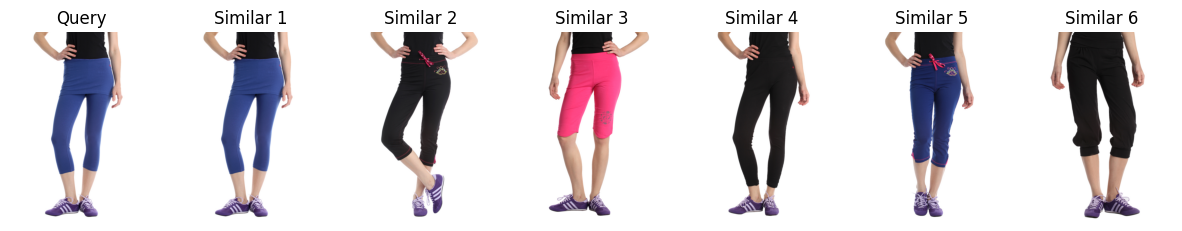

In [11]:
import matplotlib.pyplot as plt

def show_results(query, results):
    plt.figure(figsize=(15,5))

    # Query
    plt.subplot(1, len(results)+1, 1)
    plt.imshow(image.load_img(query))
    plt.title("Query")
    plt.axis('off')

    # Results
    for i, res in enumerate(results):
        plt.subplot(1, len(results)+1, i+2)
        plt.imshow(image.load_img(res))
        plt.title(f"Similar {i+1}")
        plt.axis('off')

show_results(query_img, paths)
